# Prospect‑Theory Backtesting – Analysis Notebook
This Jupyter notebook reproduces and extends the analysis from `results_pt_avg.py`.  

It:
1. Generates rolling Bayesian Model Averaging (BMA) forecasts and historical‐mean forecasts.
2. Runs Prospect‑Theory (PT) optimisations, a MVP benchmark, a Max‑Sharpe benchmark, and a naive 1/N portfolio.
3. Calculates **annualised Sharpe ratios** (monthly data ×√12).
4. Computes **average Certainty Equivalents (CE)** across the λ/γ grid for PT methods.
5. Builds and compares **cumulative net‑return paths** for each method.
6. Presents comparison tables:
   * Strategy‑level metrics within each PT method
   * Average cumulative‑return comparison across methods
   * Same summary tables shown in the original script

---

In [1]:
# ---- Locate and add the 'functions' directory automatically -------------
import sys, pathlib, os

def add_functions_dir():
    here = pathlib.Path.cwd()          # start from current working dir
    for p in [here] + list(here.parents):
        candidate = p / "functions"
        if candidate.is_dir():
            sys.path.insert(0, str(candidate))
            print("✅  Added to sys.path:", candidate)
            return
    print("⚠️  'functions' folder not found – check your project structure")

add_functions_dir()
import prospect_optimizer as po
import evaluation as ev

✅  Added to sys.path: c:\Users\toros\OneDrive\Dokumenter\advanced_finance\speciale_repo\functions


In [2]:
# --- User settings -------------------------------------------------
strategies      = ["conservative", "aggressive"]
lambda_values   = [1.99, 2.5]
gamma_values    = [0.12, 0.20]

reference_return = 1.02**(1/12)-1  # Monthly

start_date      = "1977-06-01"
end_date        = "2016-12-01"
date_tag        = f"{start_date}_{end_date}"
%cd ..
parent_dir      = os.getcwd()
cache_dir       = "./bma_cache"

c:\Users\toros\OneDrive\Dokumenter\advanced_finance\speciale_repo


In [3]:
# --- Helper functions ---------------------------------------------
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
def annualised_sharpe(ret_series, rf=0.0):
    """Annualises the Sharpe ratio for monthly data (ex‑ante rf)."""
    excess = ret_series - rf
    return excess.mean() / excess.std(ddof=1) * np.sqrt(12)

def mean_cumulative(results_dict):
    """Equal‑weight average cumulative net‑return path over all strategies."""
    cum_paths = [
        df["Compounded Returns"].rename(key)
        for key, df in results_dict.items()
    ]
    return pd.concat(cum_paths, axis=1).mean(axis=1)

In [4]:
# --- Run back‑tests ----------------------------------------------

print("⏳ Rolling BMA forecasts …")
bma_returns = po.rolling_bma_returns(
    parent_dir, n_predictors_to_use=2,
    start_date=start_date, end_date=end_date)

historical_returns = po.load_historical_returns(
    parent_dir, start_date, end_date)

# reference_series = po.load_risk_free_rate_from_factors(
#     parent_dir, start_date, end_date)
# reference_series = po.slice_reference(reference_series, start_date, end_date)

print("⏳ Back‑testing PT by BMA …")
results_bma = po.resultgenerator_bma(
    lambda_values, gamma_values, bma_returns,
    historical_returns, strategies, date_tag, cache_dir)

print("⏳ Back‑testing PT by Historical mean …")
results_hist = po.resultgenerator_historical_mean(
    lambda_values, gamma_values, historical_returns,
    strategies, date_tag)

print("⏳ Back‑testing MVP (benchmark) …")
results_mvp = po.resultgenerator_mvp(
    lambda_values, gamma_values, historical_returns,
    strategies, date_tag)

print("⏳ Back‑testing Max‑Sharpe on BMA …")
results_bma_ms = po.resultgenerator_bma_maxsharpe(
    lambda_values, gamma_values, bma_returns,
    historical_returns, strategies, date_tag)

print("⏳ Building naive equal‑weight portfolio …")
naive = po.naive_equal_weight_portfolio(
    historical_returns, start_date, end_date)
naive_key = f"conservative_{lambda_values[0]}_{gamma_values[0]}"
results_naive = {naive_key: naive}

test_assets_returns, factor_returns = po.load_test_assets_and_factors(
    parent_dir=parent_dir,
    historical_returns=historical_returns,
    start_date=start_date,
    end_date=end_date
)

results_dict_factor_model = po.resultgenerator_factor_model(
    lambda_values=lambda_values,
    gamma_values=gamma_values,
    test_assets_returns=test_assets_returns,
    factor_returns=factor_returns,
    reference_series=reference_return,
    strategies=strategies,
    date_tag=date_tag
)

results_dict_max_sharpe = po.resultgenerator_max_sharpe(
    lambda_values=lambda_values,
    gamma_values=gamma_values,
    historical_returns=historical_returns,
    strategies=strategies,
    date_tag=date_tag
)


results_by_method = {
    "PT BMA":            results_bma,
    "PT HistMean":       results_hist,
    "PT Factor Model":  results_dict_factor_model,
    "MVP":     results_mvp,
    "MaxSharpe BMA":     results_bma_ms,
    "MaxSharpe HistMean": results_dict_max_sharpe,
    "Naive 1/N":         results_naive,
}

⏳ Rolling BMA forecasts …
Index(['Date', 'Mkt-RF', 'SMB', 'CMA', 'PEAD', 'QMJ', 'MGMT', 'PERF', 'LIQ',
       'IFCR'],
      dtype='object')
Index(['Date', 'dp', 'dy', 'ep', 'de', 'svar', 'ntis', 'tbl', 'lty', 'dfy'], dtype='object')
Processing 1987-06
Loading cached BMA initialization from: c:\Users\toros\OneDrive\Dokumenter\advanced_finance\speciale_repo\bma_cache2.0\bma_init_1987-06.pkl
Loading cached BMA predictions from: c:\Users\toros\OneDrive\Dokumenter\advanced_finance\speciale_repo\bma_cache2.0\bma_pred_1987-06.pkl
Processing 1987-07
Loading cached BMA initialization from: c:\Users\toros\OneDrive\Dokumenter\advanced_finance\speciale_repo\bma_cache2.0\bma_init_1987-07.pkl
Loading cached BMA predictions from: c:\Users\toros\OneDrive\Dokumenter\advanced_finance\speciale_repo\bma_cache2.0\bma_pred_1987-07.pkl
Processing 1987-08
Loading cached BMA initialization from: c:\Users\toros\OneDrive\Dokumenter\advanced_finance\speciale_repo\bma_cache2.0\bma_init_1987-08.pkl
Loading cached 

In [5]:
results_by_method #For hver af metoderne skal vi regne prospect value for hver eneste aktualiseret return. 

for key, df in results_by_method.items():
    # Calculate the prospect value for each strategy
    print(df)

{'conservative_1.99_0.12':             Portfolio Returns  Compounded Returns  \
1987-07-01           0.008558            1.008558   
1987-08-01           0.016334            1.025032   
1987-09-01           0.004113            1.029248   
1987-10-01           0.008319            1.037811   
1987-11-01          -0.017389            1.019764   
...                       ...                 ...   
2016-08-01           0.012141            7.122391   
2016-09-01           0.000484            7.125840   
2016-10-01          -0.018146            6.996534   
2016-11-01           0.010312            7.068682   
2016-12-01           0.020076            7.210591   

                                            Portfolio Weights  \
1987-07-01  [0.0401, 0.0, 0.0, 0.1259, 0.0, 0.4527, 0.2819...   
1987-08-01  [0.0966, 0.0, -0.0, -0.0, 0.0, 0.5494, 0.2614,...   
1987-09-01  [0.1016, -0.0, 0.0, -0.0, -0.0, 0.5535, 0.2589...   
1987-10-01  [0.1331, -0.0, -0.0, -0.0, -0.0, 0.5427, 0.244...   
1987-11-01 

In [6]:
test_assets_returns

,Mkt-RF,SMB,CMA,PEAD,QMJ,MGMT,PERF,LIQ,IFCR
Date,,,,,,,,,
1977-06-01,0.0471,0.0207,-0.0122,0.002542,-0.008333,-0.009977,0.010016,0.0204,0.067700
1977-07-01,-0.0169,0.0182,0.0001,-0.007776,0.009184,0.011125,0.003183,0.0065,0.007800
1977-08-01,-0.0175,0.0089,-0.0062,0.019276,0.030540,-0.006110,0.026611,0.0295,-0.017700
1977-09-01,-0.0027,0.0156,-0.0084,0.010915,0.003504,-0.001179,0.017279,0.0136,-0.022500
1977-10-01,-0.0438,0.0150,-0.0046,-0.008172,0.010512,0.008145,0.003757,-0.0069,-0.068400
...,...,...,...,...,...,...,...,...,...
2016-08-01,0.0050,0.0172,-0.0039,-0.010773,0.001626,0.018547,-0.049411,0.0076,0.077112
2016-09-01,0.0025,0.0174,-0.0009,0.039229,-0.031290,-0.009430,-0.021728,0.0235,-0.032019
2016-10-01,-0.0202,-0.0401,0.0024,-0.013634,0.027660,0.032443,0.020009,-0.0101,0.062624


In [7]:
# --- Performance summary ------------------------------------------
summary_frames = []
for mname, rdict in results_by_method.items():
    s = po.summarize_backtest_results(rdict)
    # Replace monthly Sharpe with annualised version
    s["Sharpe Ratio"] = [annualised_sharpe(df["Portfolio Returns"]) for df in rdict.values()]
    
    s["Method"] = mname
    summary_frames.append(s.reset_index())

perf_df = pd.concat(summary_frames).set_index("Strategy_Key")
print("Strategy‑level performance (annualised SR):")
display(perf_df[["Method", "Sharpe Ratio", "Std Dev", "Mean Return","Final Wealth", "HHI", "Prospect Value"]])

Strategy‑level performance (annualised SR):


,Method,Sharpe Ratio,Std Dev,Mean Return,Final Wealth,HHI,Prospect Value
Strategy_Key,,,,,,,
aggressive_2.5_0.2,PT BMA,1.195573,0.012642,0.005332,6.387481,0.241261,-0.002778
conservative_2.5_0.2,PT BMA,1.202901,0.012655,0.005331,6.385689,0.241731,-0.002815
aggressive_2.5_0.12,PT BMA,0.594445,0.013180,0.005347,6.405582,0.250194,-0.002096
conservative_2.5_0.12,PT BMA,1.259536,0.013213,0.005355,6.422983,0.250655,-0.002097
aggressive_1.99_0.2,PT BMA,1.403876,0.015165,0.005514,6.726685,0.285476,0.000787
aggressive_1.99_0.12,PT BMA,1.405223,0.016520,0.005737,7.220581,0.304051,0.000494
conservative_1.99_0.12,PT BMA,1.459246,0.016615,0.005734,7.210591,0.304886,0.000452
conservative_1.99_0.2,PT BMA,1.460986,0.029683,0.005094,5.121438,0.408156,-0.006164
conservative_2.5_0.2,PT HistMean,1.224691,0.012539,0.005424,6.602531,0.262475,-0.002589


In [8]:


comparison_df = po.compare_methods(results_by_method)
comparison_df


,Strategy,Lambda,Gamma,Mean Return,Std Dev,Sharpe Ratio,HHI,Final Wealth,Max Drawdown,Prospect Value,Sum of Prospect Values,Method
Strategy_Key,,,,,,,,,,,,
aggressive_1.99_0.12,aggressive,1.99,0.12,0.004756,0.010045,0.473455,0.114782,5.269587,0.811330,0.001230,0.435274,MVP
aggressive_1.99_0.12,aggressive,1.99,0.12,0.004671,0.009241,0.505463,0.181500,5.127604,0.803622,0.001644,0.582125,MaxSharpe BMA
aggressive_1.99_0.12,aggressive,1.99,0.12,0.004271,0.008622,0.495408,0.193426,4.463257,0.776300,0.001093,0.387085,MaxSharpe HistMean
aggressive_1.99_0.12,aggressive,1.99,0.12,0.005737,0.016520,0.347248,0.304051,7.220581,0.862093,0.000494,0.174910,PT BMA
aggressive_1.99_0.12,aggressive,1.99,0.12,0.005931,0.016437,0.360815,0.423415,7.738015,0.871895,0.000486,0.172036,PT Factor Model
aggressive_1.99_0.12,aggressive,1.99,0.12,0.005524,0.015314,0.360724,0.312289,6.745722,0.853552,0.000294,0.104175,PT HistMean
aggressive_1.99_0.2,aggressive,1.99,0.20,0.004756,0.010045,0.473455,0.114782,5.269587,0.811330,0.001719,0.608666,MVP
aggressive_1.99_0.2,aggressive,1.99,0.20,0.004671,0.009241,0.505463,0.181500,5.127604,0.803622,0.002489,0.880970,MaxSharpe BMA
aggressive_1.99_0.2,aggressive,1.99,0.20,0.004271,0.008622,0.495408,0.193426,4.463257,0.776300,0.001602,0.567223,MaxSharpe HistMean


In [9]:
comparison_df = ev.add_certainty_equivalent_to_comparison_df(comparison_df, reference=reference_return)
comparison_df

,Strategy,Lambda,Gamma,Mean Return,Std Dev,Sharpe Ratio,HHI,Final Wealth,Max Drawdown,Prospect Value,Sum of Prospect Values,Method,Certainty Equivalent
Strategy_Key,,,,,,,,,,,,,
aggressive_1.99_0.12,aggressive,1.99,0.12,0.004756,0.010045,0.473455,0.114782,5.269587,0.811330,0.001230,0.435274,MVP,0.003104
aggressive_1.99_0.12,aggressive,1.99,0.12,0.004671,0.009241,0.505463,0.181500,5.127604,0.803622,0.001644,0.582125,MaxSharpe BMA,0.003019
aggressive_1.99_0.12,aggressive,1.99,0.12,0.004271,0.008622,0.495408,0.193426,4.463257,0.776300,0.001093,0.387085,MaxSharpe HistMean,0.002620
aggressive_1.99_0.12,aggressive,1.99,0.12,0.005737,0.016520,0.347248,0.304051,7.220581,0.862093,0.000494,0.174910,PT BMA,0.004085
aggressive_1.99_0.12,aggressive,1.99,0.12,0.005931,0.016437,0.360815,0.423415,7.738015,0.871895,0.000486,0.172036,PT Factor Model,0.004279
aggressive_1.99_0.12,aggressive,1.99,0.12,0.005524,0.015314,0.360724,0.312289,6.745722,0.853552,0.000294,0.104175,PT HistMean,0.003872
aggressive_1.99_0.2,aggressive,1.99,0.20,0.004756,0.010045,0.473455,0.114782,5.269587,0.811330,0.001719,0.608666,MVP,0.003104
aggressive_1.99_0.2,aggressive,1.99,0.20,0.004671,0.009241,0.505463,0.181500,5.127604,0.803622,0.002489,0.880970,MaxSharpe BMA,0.003019
aggressive_1.99_0.2,aggressive,1.99,0.20,0.004271,0.008622,0.495408,0.193426,4.463257,0.776300,0.001602,0.567223,MaxSharpe HistMean,0.002620


In [10]:
comparison_df

,Strategy,Lambda,Gamma,Mean Return,Std Dev,Sharpe Ratio,HHI,Final Wealth,Max Drawdown,Prospect Value,Sum of Prospect Values,Method,Certainty Equivalent
Strategy_Key,,,,,,,,,,,,,
aggressive_1.99_0.12,aggressive,1.99,0.12,0.004756,0.010045,0.473455,0.114782,5.269587,0.811330,0.001230,0.435274,MVP,0.003104
aggressive_1.99_0.12,aggressive,1.99,0.12,0.004671,0.009241,0.505463,0.181500,5.127604,0.803622,0.001644,0.582125,MaxSharpe BMA,0.003019
aggressive_1.99_0.12,aggressive,1.99,0.12,0.004271,0.008622,0.495408,0.193426,4.463257,0.776300,0.001093,0.387085,MaxSharpe HistMean,0.002620
aggressive_1.99_0.12,aggressive,1.99,0.12,0.005737,0.016520,0.347248,0.304051,7.220581,0.862093,0.000494,0.174910,PT BMA,0.004085
aggressive_1.99_0.12,aggressive,1.99,0.12,0.005931,0.016437,0.360815,0.423415,7.738015,0.871895,0.000486,0.172036,PT Factor Model,0.004279
aggressive_1.99_0.12,aggressive,1.99,0.12,0.005524,0.015314,0.360724,0.312289,6.745722,0.853552,0.000294,0.104175,PT HistMean,0.003872
aggressive_1.99_0.2,aggressive,1.99,0.20,0.004756,0.010045,0.473455,0.114782,5.269587,0.811330,0.001719,0.608666,MVP,0.003104
aggressive_1.99_0.2,aggressive,1.99,0.20,0.004671,0.009241,0.505463,0.181500,5.127604,0.803622,0.002489,0.880970,MaxSharpe BMA,0.003019
aggressive_1.99_0.2,aggressive,1.99,0.20,0.004271,0.008622,0.495408,0.193426,4.463257,0.776300,0.001602,0.567223,MaxSharpe HistMean,0.002620


In [11]:
comparison_df

,Strategy,Lambda,Gamma,Mean Return,Std Dev,Sharpe Ratio,HHI,Final Wealth,Max Drawdown,Prospect Value,Sum of Prospect Values,Method,Certainty Equivalent
Strategy_Key,,,,,,,,,,,,,
aggressive_1.99_0.12,aggressive,1.99,0.12,0.004756,0.010045,0.473455,0.114782,5.269587,0.811330,0.001230,0.435274,MVP,0.003104
aggressive_1.99_0.12,aggressive,1.99,0.12,0.004671,0.009241,0.505463,0.181500,5.127604,0.803622,0.001644,0.582125,MaxSharpe BMA,0.003019
aggressive_1.99_0.12,aggressive,1.99,0.12,0.004271,0.008622,0.495408,0.193426,4.463257,0.776300,0.001093,0.387085,MaxSharpe HistMean,0.002620
aggressive_1.99_0.12,aggressive,1.99,0.12,0.005737,0.016520,0.347248,0.304051,7.220581,0.862093,0.000494,0.174910,PT BMA,0.004085
aggressive_1.99_0.12,aggressive,1.99,0.12,0.005931,0.016437,0.360815,0.423415,7.738015,0.871895,0.000486,0.172036,PT Factor Model,0.004279
aggressive_1.99_0.12,aggressive,1.99,0.12,0.005524,0.015314,0.360724,0.312289,6.745722,0.853552,0.000294,0.104175,PT HistMean,0.003872
aggressive_1.99_0.2,aggressive,1.99,0.20,0.004756,0.010045,0.473455,0.114782,5.269587,0.811330,0.001719,0.608666,MVP,0.003104
aggressive_1.99_0.2,aggressive,1.99,0.20,0.004671,0.009241,0.505463,0.181500,5.127604,0.803622,0.002489,0.880970,MaxSharpe BMA,0.003019
aggressive_1.99_0.2,aggressive,1.99,0.20,0.004271,0.008622,0.495408,0.193426,4.463257,0.776300,0.001602,0.567223,MaxSharpe HistMean,0.002620


In [ ]:
# --- Detailed PT method tables ------------------------------------
pt_methods = ["PT BMA", "PT HistMean", "PT Factor Model"]
for m in pt_methods:
    display(pd.DataFrame({
        "Final Wealth": comparison_df[comparison_df.Method == m]["Final Wealth"],
        
        
        "Max Drawdown": comparison_df[comparison_df.Method == m]["Max Drawdown"],
        "HHI": comparison_df[comparison_df.Method == m]["HHI"],
       "Sharpe Ratio": comparison_df[comparison_df.Method == m]["Sharpe Ratio"]*np.sqrt(12),
        "Mean Return": comparison_df[comparison_df.Method == m]["Mean Return"],
        "Std Dev": comparison_df[comparison_df.Method == m]["Std Dev"],
        
        
        "Certainty Equivalance": comparison_df[comparison_df.Method == m]["Certainty Equivalent"],
        "Prospect Value": comparison_df[comparison_df.Method == m]["Sum of Prospect Values"]    #   "HHI": comparison_df[comparison_df.Method == m]["HHI"],
    }).sort_values("Sharpe Ratio", ascending=False).style.set_caption(f"{m} – Strategy‑level Results"))

,Final Wealth,Max Drawdown,HHI,Sharpe Ratio,Mean Return,Std Dev,Certainty Equivalance,Prospect Value
Strategy_Key,,,,,,,,
aggressive_2.5_0.2,6.387481,0.842340,0.241261,1.460986,0.005332,0.012642,0.003680,-0.002778
conservative_2.5_0.2,6.385689,0.842364,0.241731,1.459246,0.005331,0.012655,0.003679,-0.002815
aggressive_2.5_0.12,6.405582,0.843089,0.250194,1.405223,0.005347,0.013180,0.003695,-0.002096
conservative_2.5_0.12,6.422983,0.843581,0.250655,1.403876,0.005355,0.013213,0.003703,-0.002097
aggressive_1.99_0.2,6.726685,0.852006,0.285476,1.259536,0.005514,0.015165,0.003862,0.000787
aggressive_1.99_0.12,7.220581,0.862093,0.304051,1.202901,0.005737,0.016520,0.004085,0.000494
conservative_1.99_0.12,7.210591,0.862011,0.304886,1.195573,0.005734,0.016615,0.004083,0.000452
conservative_1.99_0.2,5.121438,0.803995,0.408156,0.594445,0.005094,0.029683,0.003442,-0.006164


,Final Wealth,Max Drawdown,HHI,Sharpe Ratio,Mean Return,Std Dev,Certainty Equivalance,Prospect Value
Strategy_Key,,,,,,,,
conservative_2.5_0.2,6.602531,0.850241,0.262475,1.498473,0.005424,0.012539,0.003773,-0.002589
aggressive_2.5_0.12,6.666820,0.851313,0.272412,1.483699,0.005454,0.012734,0.003803,-0.001681
aggressive_2.5_0.2,6.399399,0.845736,0.262228,1.464672,0.005336,0.012621,0.003685,-0.003132
conservative_2.5_0.12,6.511464,0.848424,0.272805,1.434587,0.005391,0.013017,0.003739,-0.001989
conservative_1.99_0.2,6.954635,0.858607,0.300663,1.335694,0.005599,0.014520,0.003947,0.001073
aggressive_1.99_0.2,6.760718,0.853863,0.298811,1.307921,0.005520,0.014619,0.003868,0.000740
aggressive_1.99_0.12,6.745722,0.853552,0.312289,1.249584,0.005524,0.015314,0.003872,0.000294
conservative_1.99_0.12,6.863662,0.856251,0.312815,1.224691,0.005581,0.015785,0.003929,0.000311


,Final Wealth,Max Drawdown,HHI,Sharpe Ratio,Mean Return,Std Dev,Certainty Equivalance,Prospect Value
Strategy_Key,,,,,,,,
aggressive_2.5_0.2,7.244383,0.862192,0.412966,1.330838,0.005719,0.014886,0.004067,-0.003756
conservative_2.5_0.12,7.388965,0.864800,0.412007,1.330068,0.005777,0.015047,0.004126,-0.002283
conservative_2.5_0.2,7.151531,0.860229,0.413074,1.323168,0.005682,0.014876,0.004031,-0.003897
aggressive_2.5_0.12,7.158387,0.861007,0.409282,1.318103,0.005686,0.014943,0.004034,-0.002370
conservative_1.99_0.2,7.789265,0.872254,0.426087,1.276021,0.005945,0.016139,0.004293,0.001221
aggressive_1.99_0.2,7.591785,0.869422,0.422879,1.260628,0.005871,0.016134,0.004220,0.000738
aggressive_1.99_0.12,7.738015,0.871895,0.423415,1.249900,0.005931,0.016437,0.004279,0.000486
conservative_1.99_0.12,7.571747,0.868412,0.425290,1.226673,0.005871,0.016581,0.004220,0.000426


In [ ]:
# 1. (Re-)define the list of metrics you care about
metrics = [
    "Final Wealth",
    "Max Drawdown",
    "HHI",
    "Mean Return",
    "Std Dev",
    "Certainty Equivalent",
    "Prospect Value"
]

# 2. Build an aggregation dictionary
agg_dict = {
    # take the mean of these raw metrics
    **{m: (m, "mean") for m in metrics},
    # annualize Sharpe
    "Sharpe Ratio (ann.)": ("Sharpe Ratio", lambda x: x.mean() * np.sqrt(12))
}

# 3. Group by Method and aggregate
summary_df = (
    comparison_df
      .groupby("Method")
      .agg(**agg_dict)
      # optional: reorder columns
      .loc[:, [
          "Final Wealth",
          "Max Drawdown",
          "HHI",
          "Sharpe Ratio (ann.)",
          "Mean Return",
          "Std Dev",
          "Certainty Equivalent",
          "Prospect Value"
      ]]
)

# 4. Pretty‐print
display(
    summary_df
      .style
      .format("{:.4f}")
      .set_caption("Average Metrics by Method")
)

,Final Wealth,Max Drawdown,HHI,Sharpe Ratio (ann.),Mean Return,Std Dev,Certainty Equivalent,Sum of Prospect Values
Method,,,,,,,,
MVP,5.2696,0.8113,0.1148,1.6401,0.0048,0.0100,0.0031,-0.0250
MaxSharpe BMA,5.1276,0.8036,0.1815,1.7510,0.0047,0.0092,0.0030,0.2381
MaxSharpe HistMean,4.4633,0.7763,0.1934,1.7161,0.0043,0.0086,0.0026,0.0067
Naive 1/N,6.1329,0.8434,0.1111,1.6734,0.0052,0.0107,0.0035,0.6929
PT BMA,6.4851,0.8439,0.2858,1.2477,0.0054,0.0162,0.0038,-0.6291
PT Factor Model,7.4543,0.8663,0.4181,1.2894,0.0058,0.0156,0.0042,-0.4176
PT HistMean,6.6881,0.8522,0.2868,1.3749,0.0055,0.0139,0.0038,-0.3085


In [14]:
# --- Average cumulative net‑return comparison ---------------------
cum_net_df = pd.DataFrame({m: mean_cumulative(r) for m, r in results_by_method.items()})
display(cum_net_df.tail())  # show last few rows

final_wealth = cum_net_df.iloc[-1].rename("Final Wealth")
display(final_wealth.to_frame().T.style.set_caption("Final Wealth (average of strategies)") )

,PT BMA,PT HistMean,PT Factor Model,MVP,MaxSharpe BMA,MaxSharpe HistMean,Naive 1/N
2016-08-01,6.382877,6.513266,7.248419,5.033428,5.012654,4.324972,5.857994
2016-09-01,6.393759,6.410099,7.114185,5.026305,5.028169,4.269705,5.849703
2016-10-01,6.278808,6.458614,7.182776,5.060426,4.958626,4.299415,5.889417
2016-11-01,6.341857,6.596531,7.340202,5.236059,5.001940,4.410916,6.093842
2016-12-01,6.485129,6.688119,7.454260,5.269587,5.127604,4.463257,6.132867


,PT BMA,PT HistMean,PT Factor Model,MVP,MaxSharpe BMA,MaxSharpe HistMean,Naive 1/N
Final Wealth,6.485129,6.688119,7.454260,5.269587,5.127604,4.463257,6.132867


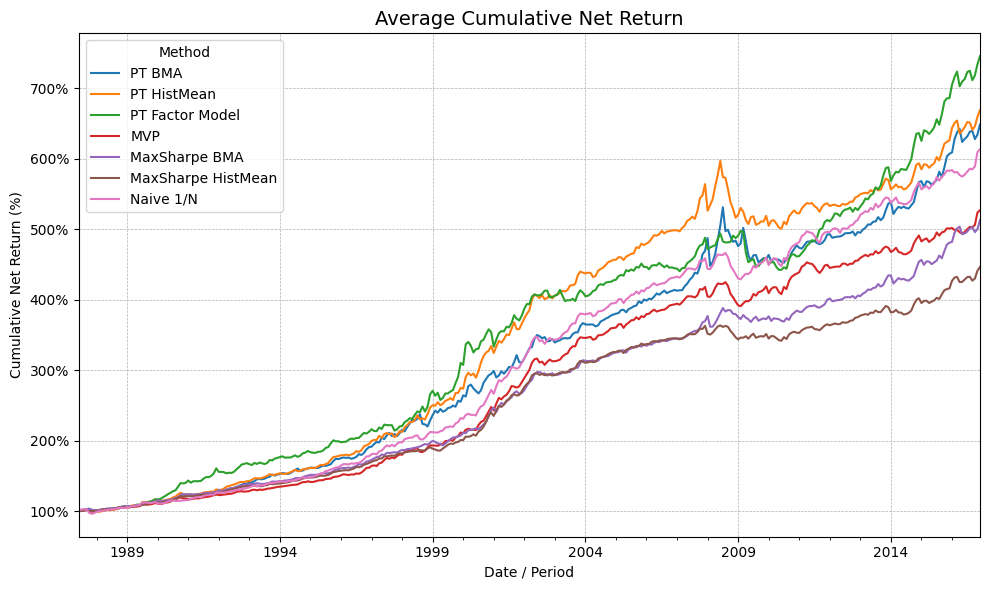

In [15]:
%matplotlib inline     
from matplotlib.ticker import FuncFormatter  
cum_net_df = pd.DataFrame({m: mean_cumulative(r) for m, r in results_by_method.items()})

ax = cum_net_df.plot(figsize=(10, 6))
ax.set_title("Average Cumulative Net Return", fontsize=14)
ax.set_xlabel("Date / Period")
ax.set_ylabel("Cumulative Net Return (%)")

# multiply each tick value by 100 just for display
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y*100:.0f}%'))

ax.legend(title="Method", loc="best")
ax.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()

In [16]:
results_by_method

{'PT BMA': {'conservative_1.99_0.12':             Portfolio Returns  Compounded Returns  \
  1987-07-01           0.008558            1.008558   
  1987-08-01           0.016334            1.025032   
  1987-09-01           0.004113            1.029248   
  1987-10-01           0.008319            1.037811   
  1987-11-01          -0.017389            1.019764   
  ...                       ...                 ...   
  2016-08-01           0.012141            7.122391   
  2016-09-01           0.000484            7.125840   
  2016-10-01          -0.018146            6.996534   
  2016-11-01           0.010312            7.068682   
  2016-12-01           0.020076            7.210591   
  
                                              Portfolio Weights  \
  1987-07-01  [0.0401, 0.0, 0.0, 0.1259, 0.0, 0.4527, 0.2819...   
  1987-08-01  [0.0966, 0.0, -0.0, -0.0, 0.0, 0.5494, 0.2614,...   
  1987-09-01  [0.1016, -0.0, 0.0, -0.0, -0.0, 0.5535, 0.2589...   
  1987-10-01  [0.1331, -0.0, -0.0

In [17]:
# --- Average Certainty Equivalents -------------------------------
reference_series = po.load_risk_free_rate_from_factors(parent_dir, start_date=start_date, end_date=end_date)


# Slice according to the selected date range
reference_series = po.slice_reference(reference_series, start_date, end_date)
ce_df_all = ev.compare_certainty_equivalents(results_by_method, reference_series)
ce_summary = ev.summarize_certainty_equivalents(ce_df_all)
display(ce_summary.style.set_caption("Average Certainty Equivalent by Method"))

,CE Sum,CE Mean,CE Std Dev,CE Median
Method,,,,
Naive 1/N,0.000721,0.000721,nan,0.000721
MaxSharpe BMA,0.000593,0.000593,nan,0.000593
MVP,0.000426,0.000426,nan,0.000426
MaxSharpe HistMean,0.000373,0.000373,nan,0.000373
PT BMA,0.000137,0.000137,nan,0.000137
PT Factor Model,0.000128,0.000128,nan,0.000128
PT HistMean,0.000090,0.000090,nan,0.000090


In [18]:
# ── 1  Run the PT Factor back-test (replace with your own generator) ─────────
print("⏳ Back-testing PT by Factor model …")
#results_factor = po.resultgenerator_factor(          # ← use your actual func
#    lambda_values, gamma_values,
#    #factor_returns,                 # e.g. po.load_factor_returns(...)
#    historical_returns,
#    strategies, date_tag)

# ── 2  Collect every method in one dict ──────────────────────────────────────
results_by_method = {
    "PT BMA":            results_bma,
    "PT HistMean":       results_hist,
    "PT Factor Model":         results_dict_factor_model,           # ← newly added
    "MVP":     results_mvp,
    "MaxSharpe HistMean": results_dict_max_sharpe,
    "MaxSharpe BMA":     results_bma_ms,
    "Naive 1/N":         results_naive,
}

# ── 3  Average cumulative net-return path per method ‐ and final wealth ─────
cum_net_df   = pd.DataFrame({m: mean_cumulative(r) for m, r in results_by_method.items()})
final_wealth = cum_net_df.iloc[-1].rename("Final Wealth")        # Series: index = method

# ── 4  Transposed table – each method in its own row ────────────────────────
final_wealth_tbl = final_wealth.to_frame(name="Final Wealth")    # already transposed
display(final_wealth_tbl.style.set_caption("Final Wealth (average of strategies) – transposed"))

# ── 5  OPTIONAL: add more benchmark metrics on the same rows ────────────────
# Annualised Sharpe (already in perf_df) – take mean across strategies
avg_sharpe = perf_df.groupby("Method")["Sharpe Ratio"].mean()

# Certainty Equivalent mean (already in ce_summary)
avg_ce = ce_summary["CE Mean"]

benchmark_df = pd.concat([final_wealth, avg_sharpe, avg_ce], axis=1)
benchmark_df.columns = ["Final Wealth", "Annualised Sharpe", "Average CE"]
benchmark_df = benchmark_df.loc[results_by_method.keys()]        # keep row order tidy
display(benchmark_df.style.set_caption("Benchmark metrics by method (transposed)"))

⏳ Back-testing PT by Factor model …


,Final Wealth
PT BMA,6.485129
PT HistMean,6.688119
PT Factor Model,7.454260
MVP,5.269587
MaxSharpe HistMean,4.463257
MaxSharpe BMA,5.127604
Naive 1/N,6.132867


,Final Wealth,Annualised Sharpe,Average CE
PT BMA,6.485129,1.247723,0.000137
PT HistMean,6.688119,1.374915,0.000090
PT Factor Model,7.454260,1.289425,0.000128
MVP,5.269587,1.640097,0.000426
MaxSharpe HistMean,4.463257,1.716143,0.000373
MaxSharpe BMA,5.127604,1.750974,0.000593
Naive 1/N,6.132867,1.673375,0.000721


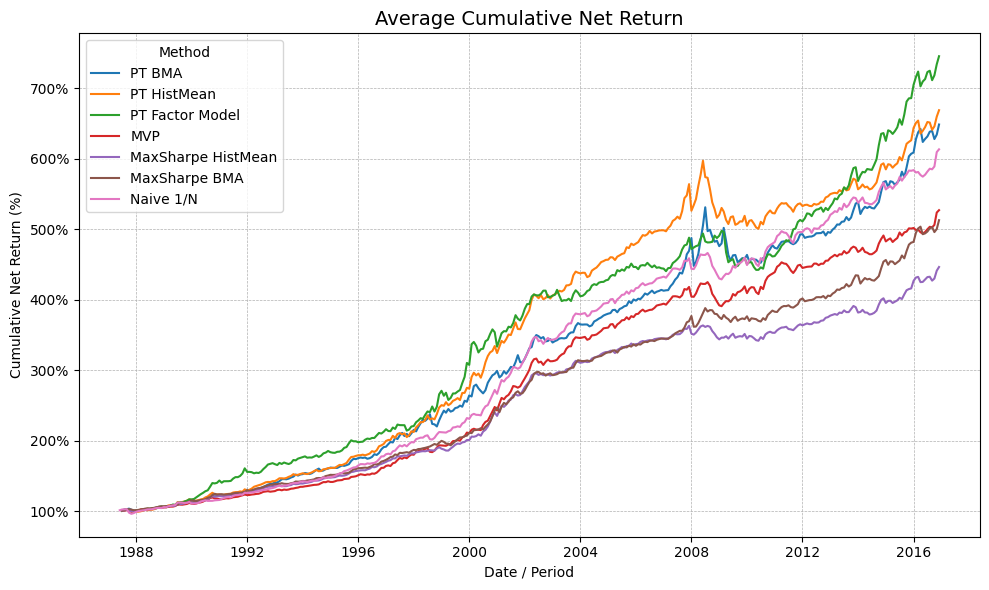

In [19]:
plt.figure(figsize=(10, 6))
for col in cum_net_df.columns:
    plt.plot(cum_net_df.index, cum_net_df[col], label=col)

# grab current axes
ax = plt.gca()

# titles & labels
ax.set_title("Average Cumulative Net Return", fontsize=14)
ax.set_xlabel("Date / Period")
ax.set_ylabel("Cumulative Net Return (%)")

# format y-axis ticks as percentages
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y*100:.0f}%'))

# legend with title and best location
ax.legend(title="Method", loc="best")

# light dashed gridlines
ax.grid(True, linestyle="--", linewidth=0.5)

# tighten up margins
plt.tight_layout()

plt.show()

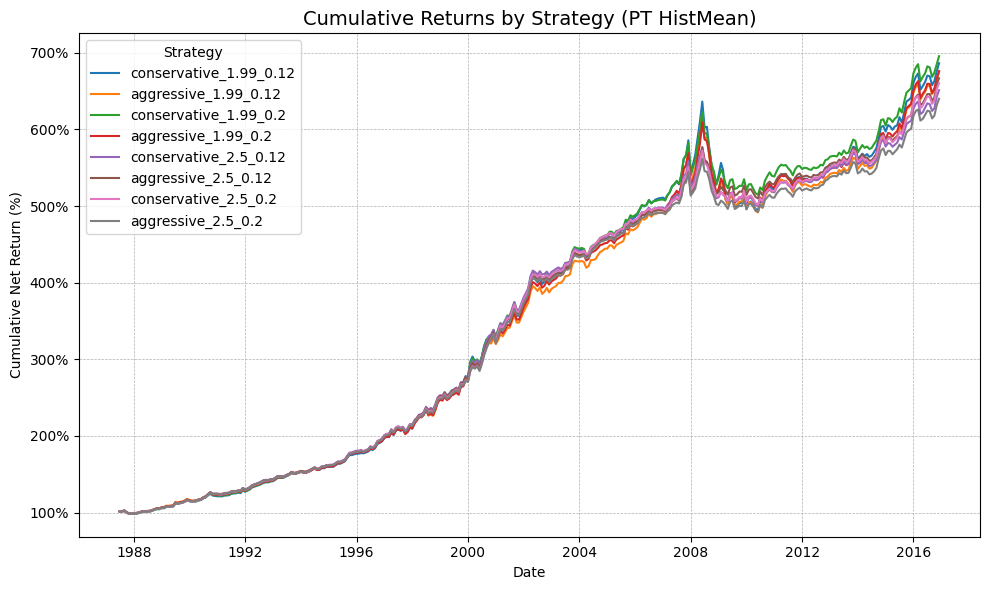

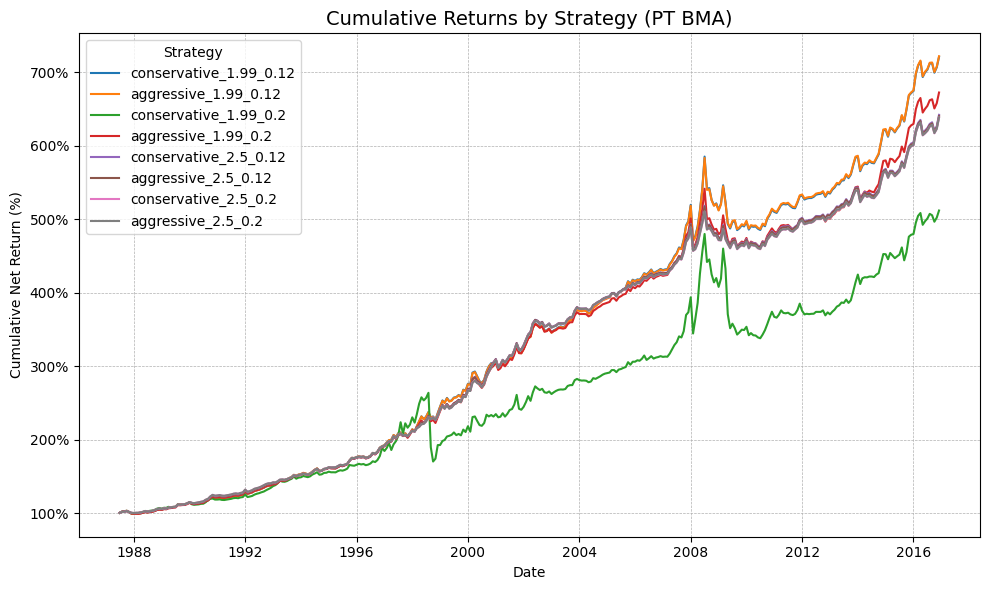

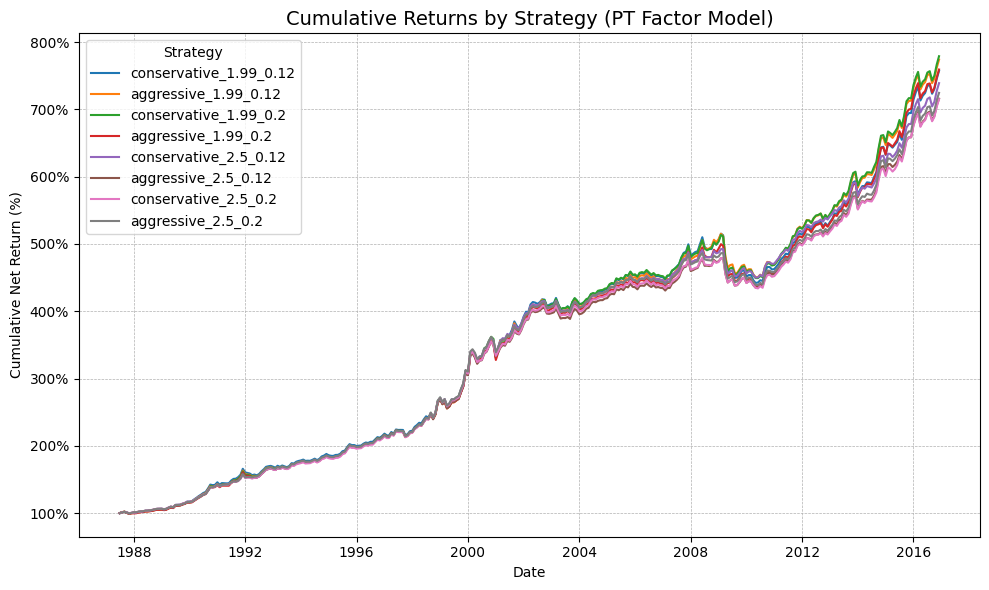

In [25]:
# Define the methods to plot separately
pt_methods = ["PT HistMean", "PT BMA", "PT Factor Model"]

# Loop through each method and plot cumulative returns for each strategy
for method in pt_methods:
    plt.figure(figsize=(10, 6))
    for strategy_name, strategy_df in results_by_method[method].items():
        cumulative_returns = (1 + strategy_df['Portfolio Returns']).cumprod()
        plt.plot(cumulative_returns.index, cumulative_returns, label=strategy_name)

    # Grab current axes
    ax = plt.gca()

    # Titles & labels
    ax.set_title(f"Cumulative Returns by Strategy ({method})", fontsize=14)
    ax.set_xlabel("Date")
    ax.set_ylabel("Cumulative Net Return (%)")

    # Format y-axis ticks as percentages
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y*100:.0f}%'))

    # Legend with title and best location
    ax.legend(title="Strategy", loc="best")

    # Light dashed gridlines
    ax.grid(True, linestyle="--", linewidth=0.5)

    # Tighten up margins
    plt.tight_layout()

    plt.show()

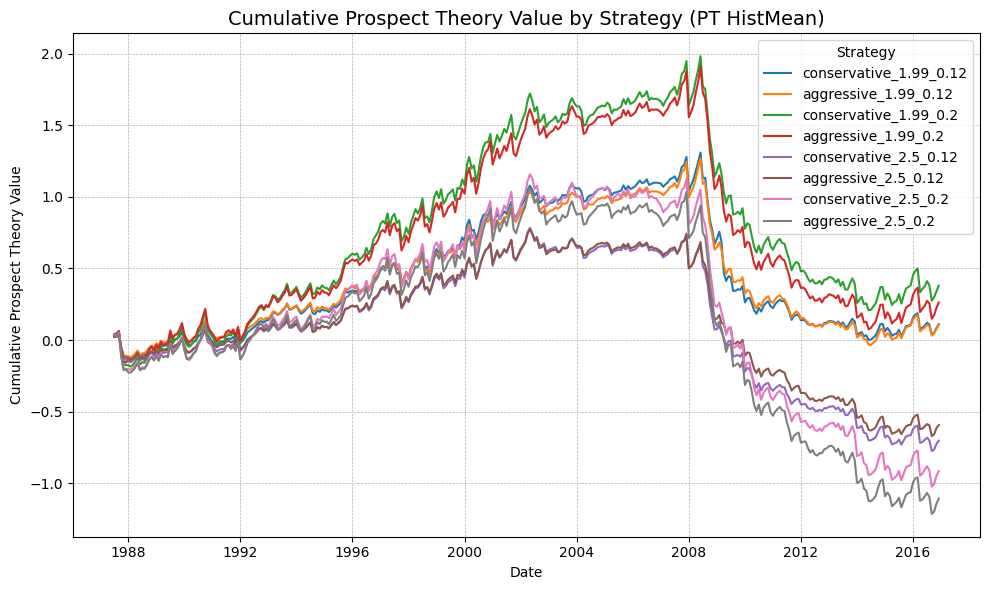

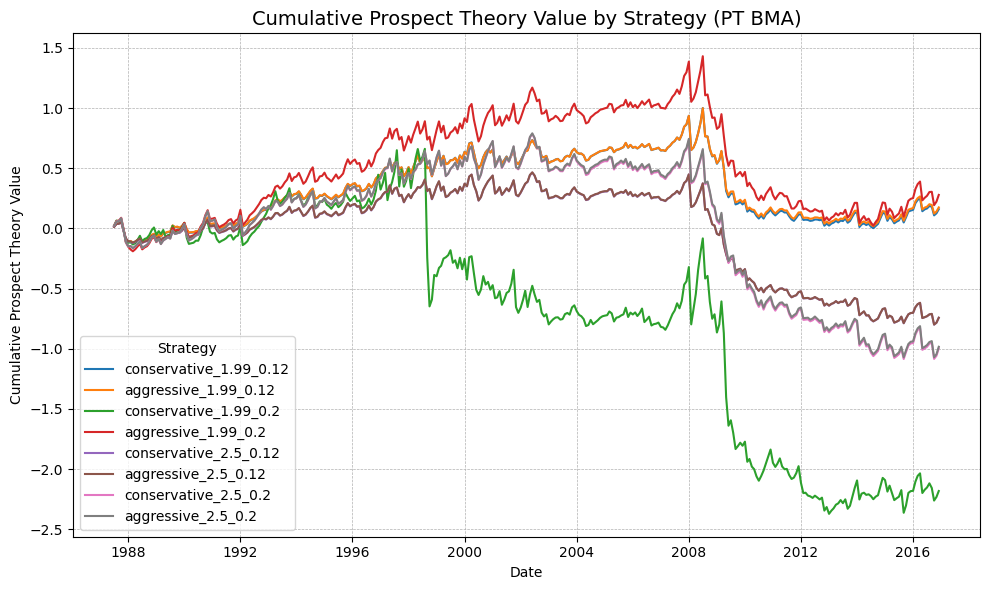

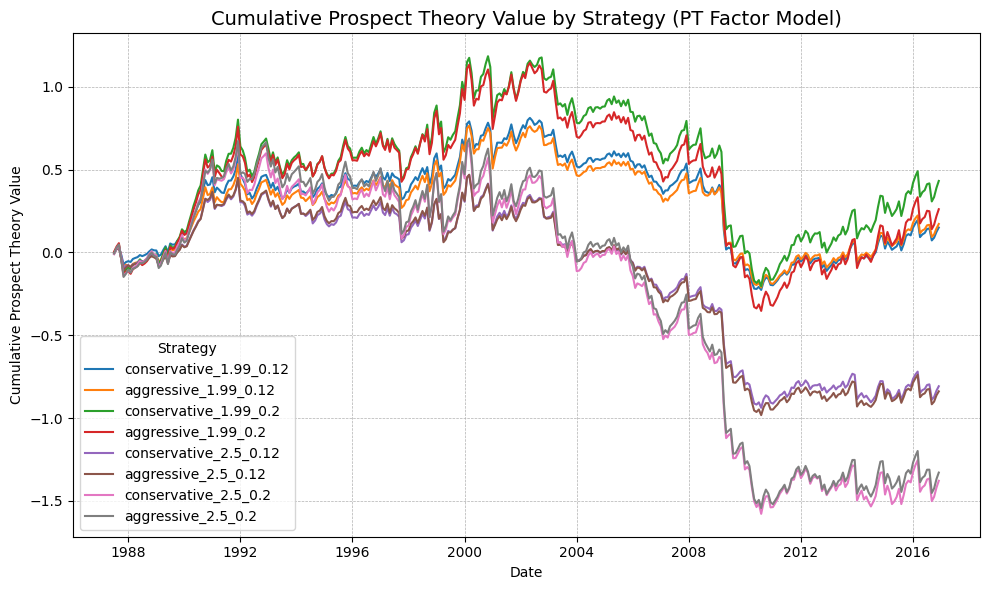

In [26]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Define the methods to plot separately
pt_methods = ["PT HistMean", "PT BMA", "PT Factor Model"]

# Loop through each method and plot cumulative Prospect Theory values for each strategy
for method in pt_methods:
    plt.figure(figsize=(10, 6))
    for strategy_name, strategy_df in results_by_method[method].items():
        cumulative_pt_values = strategy_df['Prospect Value'].cumsum()
        plt.plot(cumulative_pt_values.index, cumulative_pt_values, label=strategy_name)

    # Grab current axes
    ax = plt.gca()

    # Titles & labels
    ax.set_title(f"Cumulative Prospect Theory Value by Strategy ({method})", fontsize=14)
    ax.set_xlabel("Date")
    ax.set_ylabel("Cumulative Prospect Theory Value")

    # Legend with title and best location
    ax.legend(title="Strategy", loc="best")

    # Light dashed gridlines
    ax.grid(True, linestyle="--", linewidth=0.5)

    # Tighten up margins
    plt.tight_layout()

    plt.show()


In [ ]:
plt.figure(figsize=(10, 6))
for col in cum_net_df.columns:
    plt.plot(cum_net_df.index, cum_net_df[col], label=col)

# grab current axes
ax = plt.gca()

# titles & labels
ax.set_title("Cumulative Prospect Value", fontsize=14)
ax.set_xlabel("Date / Period")
ax.set_ylabel("Cumulative Prospect Value")")

# format y-axis ticks as percentages
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y*100:.0f}%'))

# legend with title and best location
ax.legend(title="Method", loc="best")

# light dashed gridlines
ax.grid(True, linestyle="--", linewidth=0.5)

# tighten up margins
plt.tight_layout()

plt.show()

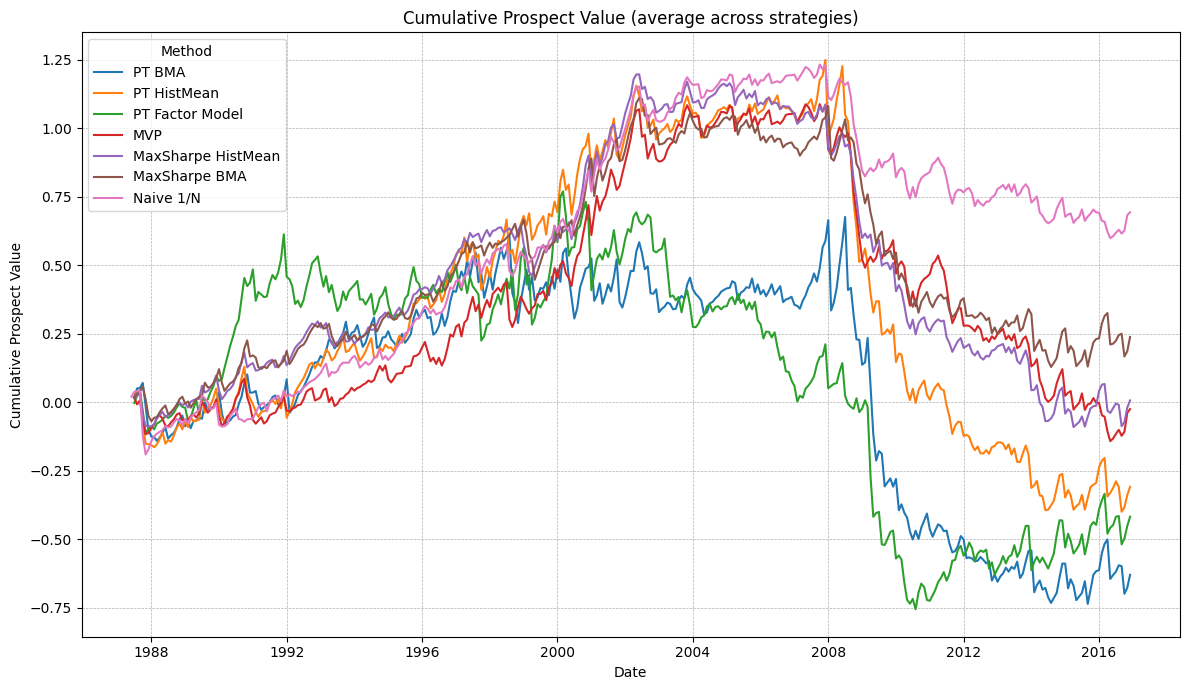

In [27]:
# Calculate cumulative sum of Prospect Values per method
cum_prospect_df = pd.DataFrame({
    method: pd.concat(
        [df['Prospect Value'].cumsum() for df in results.values()], axis=1
    ).mean(axis=1)
    for method, results in results_by_method.items()
})

# Plot the cumulative sum of Prospect Values
plt.figure(figsize=(12, 7))
for method in cum_prospect_df.columns:
    plt.plot(cum_prospect_df.index, cum_prospect_df[method], label=method)

plt.title("Cumulative Prospect Value (average across strategies)")
plt.xlabel("Date")
plt.ylabel("Cumulative Prospect Value")
plt.legend(title="Method")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

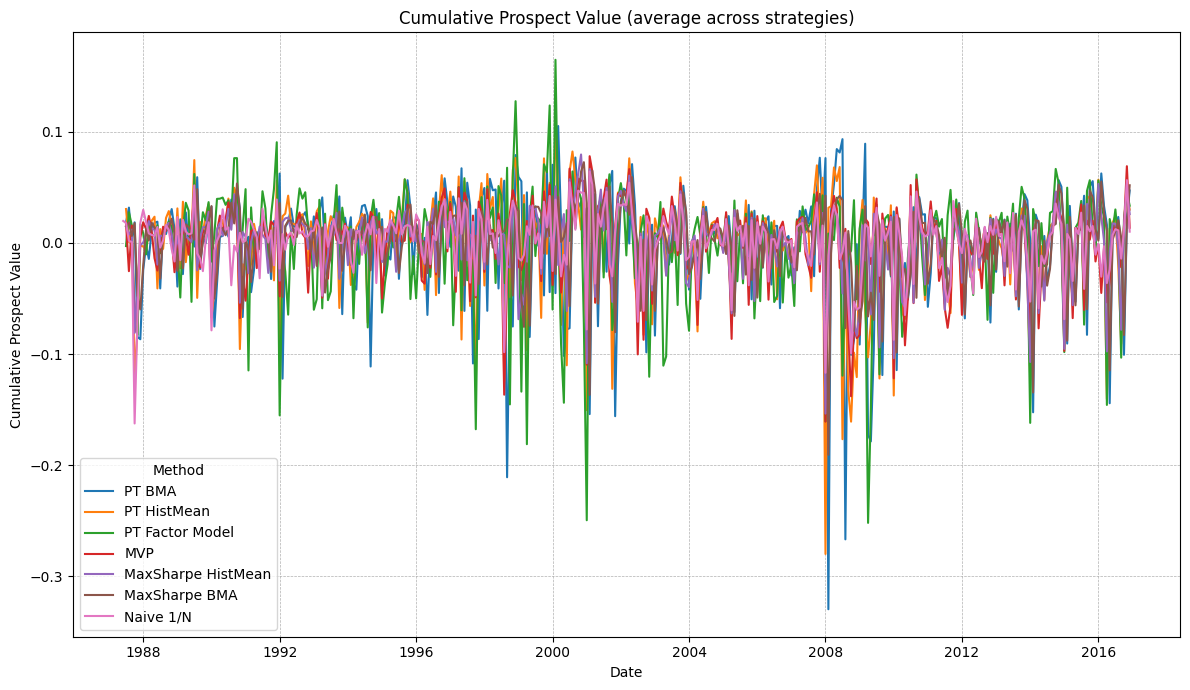

In [28]:
# Calculate cumulative sum of Prospect Values per method
cum_prospect_df = pd.DataFrame({
    method: pd.concat(
        [df['Prospect Value'] for df in results.values()], axis=1
    ).mean(axis=1)
    for method, results in results_by_method.items()
})

# Plot the cumulative sum of Prospect Values
plt.figure(figsize=(12, 7))
for method in cum_prospect_df.columns:
    plt.plot(cum_prospect_df.index, cum_prospect_df[method], label=method)

plt.title("Cumulative Prospect Value (average across strategies)")
plt.xlabel("Date")
plt.ylabel("Cumulative Prospect Value")
plt.legend(title="Method")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [ ]:
#Graf over estimation accuracy.